# Exploratory Data Analysis
---

In [21]:
import numpy as np
import pandas as pd
import imp
import mwc.viz
import mwc.stats
imp.reload(mwc.stats)
import bokeh.io
import bokeh.layouts
import bokeh.plotting
import bokeh_catplot as bkcat
import matplotlib.pyplot as plt
colors = mwc.viz.pub_style()
from bokeh.models import Dropdown, RadioButtonGroup, ColumnDataSource, Slider, Band
bokeh.io.output_notebook()
# colors, colors_list = mwc.viz.bokeh_theme()

Loading BokehJS ...

tAs of July 7, 2019, Zofii and I have collected nearly all of the data for both the carbon source variation as well as the temperature ranges. The point of this notebook is to perform some cursory exploratory data analysis with respect to the fold-change in gene expression as well as the growth rate depdent expression parameters. Ultimately, I will want to examine $\Delta F$ as a means to identify *which* parameters are changing. To begin, let's write a small Bokeh application that allows exploration of the the dilution data 

## Exploring Sizes and Rates

First things first, let's look at the size distributions of the cells. We note that we applied a filter to *only* consider cells between 0.5 µm$^2$ and 4 µm$^2$. 

In [22]:
# Load the fold-change data with the most 
fc_df = pd.read_csv('../../data/compiled_fold_change.csv')

# Convert the areas to physical units
ip_dist = 0.065
fc_df['area_um'] = fc_df['area_pix'] * ip_dist**2

In [23]:
carbon_var = fc_df[(fc_df['temp']==37) & (fc_df['strain']=='auto')]
temp_var = fc_df[(fc_df['carbon']=='glucose') & (fc_df['strain']=='auto')]
p_carbon = bkcat.histogram(carbon_var, 'carbon', 'mean_mCherry') 
p_temp = bkcat.histogram(temp_var, 'temp', 'mean_mCherry')

bokeh.io.show(bokeh.layouts.row(p_carbon, p_temp))

In [24]:
# Load the data
flucts = pd.read_csv('../../data/analyzed_fluctuations.csv')

def dilution_doc(doc):
    # Define the interactions
    button = RadioButtonGroup(labels=['carbon source variation', 'temperature variation'], active=0)
    drop1 = Dropdown(label='select carbon source', menu=[('glucose', 'glucose'), ('glycerol', 'glycerol'), ('acetate', 'acetate')], value='glucose')
    drop2 = Dropdown(label='select temperature', menu=[('42° C', '42'), ('37° C', '37'), ('32° C', '32')], value='37')
    bins = Slider(value=50, start=5, end=250, step=5, title='events per bin', bar_color=colors['purple'])

    # Define the figure canvas and layouts
    p = bokeh.plotting.figure(x_axis_type='log',y_axis_type='log', 
                             x_axis_label='I\u2081 + I\u2082',
                             y_axis_label='(I\u2081 - I\u2082)\u00b2',
                             width=600, height=400)
    row = bokeh.layouts.row(drop1, drop2)
    lay = bokeh.layouts.column(button, row, bins, p)

    # Define the source
    fluct_source = ColumnDataSource(dict(summed=[], fluct=[]))
    fit_source = ColumnDataSource(dict(I_range=[], fit=[]))
    bin_source = ColumnDataSource(dict(binned_summed=[], binned_fluct=[], fluct_low=[], fluct_high=[]))
    I_tot_range = np.logspace(2, 6, 200)
    def update():
        if button.active == 0:
            temp = 37
            carbon = drop1.value

        elif button.active == 1:
            temp = int(drop2.value)
            carbon = 'glucose'

        # Isolate the dataset 
        _df = flucts[(flucts['carbon']==carbon) & (flucts['temp']==temp)]
        alpha = _df['alpha_mu'].values[0]

        # Get the number of bins
        binning = mwc.stats.bin_by_events(_df, bins.value)
        p.title.text = f'{carbon}, {temp}°C, no antibiotic'
        fluct_source.data = dict(summed=_df['summed'], fluct=_df['fluct'])
        fit_source.data = dict(I_range=I_tot_range, fit=alpha * I_tot_range)
        bin_source.data = dict(binned_summed=binning['summed'], binned_fluct=binning['fluct'],
                              fluct_low=binning['fluct'] - binning['fluct_sem'],
                              fluct_high = binning['fluct'] + binning['fluct_sem'])


    p.circle(x='summed', y='fluct', color='black', size=1, alpha=0.5, legend='division', source=fluct_source)

    binned_uncert = Band(base='binned_summed', lower='fluct_low', upper='fluct_high', fill_alpha=0.85, fill_color=colors['light_purple'],
                        source=bin_source, level='underlay') 
    p.add_layout(binned_uncert)
    p.circle(x='binned_summed', y='binned_fluct', line_color=colors['purple'], fill_color='white', 
             legend='binned divisions', source=bin_source, line_width=2, size=8)
    p.line(x='I_range', y='fit', color=colors['orange'], line_width=2, legend='best fit', source=fit_source)
    p.legend.location = 'top_left'
    for v in [drop1, drop2, bins]:
        v.on_change('value', lambda attr, old, new: update())
    update()
    doc.add_root(lay)

bokeh.io.show(dilution_doc, notebook_handle=True, notebook_url="http://localhost:8888")


The data looks okay, some of the fits are not spectacular. There also appears to be limited data for the 32°C data set so I may need to spend some more time collecting data for that particular condition. I'm also not sure to what degree I should trust the "binned" data. 

As a sanity check, let's make sure that the glucose dilution measurements make sense with our prescribed theory.  

In [39]:
# Load the fold-change data and isolate the glucose 37 data
fc = pd.read_csv('../../data/analyzed_foldchange.csv')
fc = fc[(fc['repressors'] >= 20) &  (fc['repressors'] <= 1500) & (fc['fold_change'] >= -2)]
g37 = fc[(fc['carbon']=='acetate') & (fc['temp']==37) & (fc['strain']=='dilution') & 
        (fc['date']!=20190617) & (fc['date']!=20190611)].copy()
g37['repressors'] = np.round(g37['repressors'], decimals=-1)
grouped = g37.groupby(['date', 'repressors'])['fold_change'].agg(('mean', 'std')).reset_index()
grouped2 = grouped.groupby(['repressors'])['mean'].agg(('mean', 'sem')).reset_index()
grouped2.dropna(inplace=True)
rep_range = np.logspace(0, 3, 200)
# Compute the theoretical curve
theo = mwc.model.SimpleRepression(R=rep_range, ep_r=-13.9, ka=139, ki=0.53, effector_conc=0, ep_ai=4.5).fold_change()

In [40]:
p = bokeh.plotting.figure(x_axis_type='log', y_axis_type='log', tools=['pan', 'hover', 'wheel_zoom'])
# p.circle(g37['repressors'], g37['fold_change'], size=1)
# p.circle(2 * grouped['repressors'], grouped['mean'],  alpha=0.5, color='red')
p.circle(2 * grouped2['repressors'], grouped2['mean'], color='tomato')
p.segment(x0=2 * grouped2['repressors'], x1=2 * grouped2['repressors'], y0=grouped2['mean']-grouped2['sem'], y1=grouped2['mean'] + grouped2['sem'], color='tomato')
p.line(rep_range, theo)

bokeh.io.show(p)

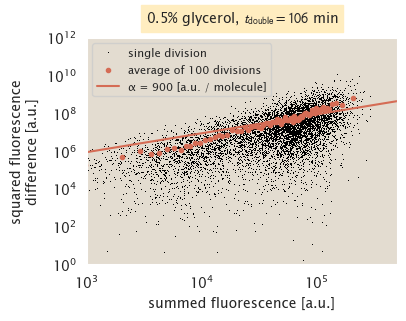

In [42]:
fig, ax = plt.subplots(1, 1, figsize=(4, 3), dpi=100)
ax.grid(False)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_ylim([1, 1E12])
ax.set_xlabel('summed fluorescence [a.u.]')
ax.set_ylabel('squared fluorescence\ndifference [a.u.]')

# Isolate the glucose case
glu = flucts[flucts['carbon']=='glycerol']
ax.plot(glu['summed'], glu['fluct'], 'k,', label='single division')

# Bin the data by 100 events
binned = mwc.stats.bin_by_events(glu, 100)
ax.plot(binned['summed'], binned['fluct'], '.', color=colors[0], label='average of 100 divisions')

# Plot the line of best fit. 
I_tot_range = np.logspace(2, 6)
alpha = glu['alpha_mu'].mean()
ax.plot(I_tot_range, alpha * I_tot_range, label='α = 900 [a.u. / molecule]',
        color=colors[0])
ax.legend(fontsize=8)
ax.set_title('0.5% glycerol, $t_\mathrm{double} = 106$ min', backgroundcolor= '#FFEDC0',
            fontsize=10, y=1.03)
ax.set_xlim([1E3, 5E5])
plt.savefig('./glucose_fluct_plot.pdf')

694.0237769971596

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Text(0.5, 1.0, 'temperature variation')

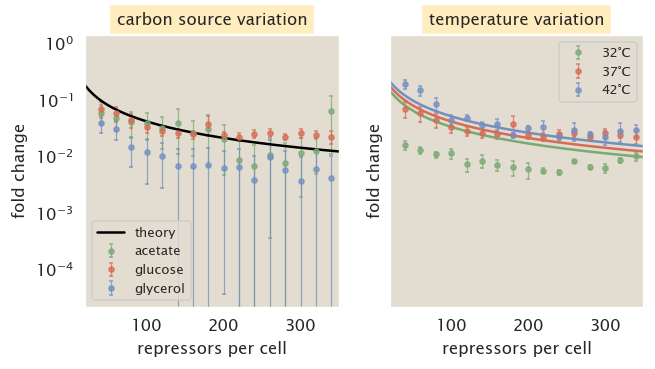

In [38]:
fc = pd.read_csv('../../data/analyzed_foldchange.csv')
fc = fc[(fc['repressors'] >= 20) &  (fc['repressors'] <= 1500) & (fc['fold_change'] >= -0.05)]
fig, ax = plt.subplots(1, 2, sharey=True, figsize=(6, 3), dpi=120)
for a in ax:
#     a.set_xscale('log')
    a.set_yscale('log')
    a.grid(False)
    a.set_xlabel('repressors per cell')
    a.set_ylabel('fold change')
    a.set_xlim([20, 350])
#     a.set_ylim([1E-4, 0.2])
#     a.set_xticks()
    
# Plot the theory curves
theoC = mwc.model.SimpleRepression(R=rep_range, ep_r=-13.9, ka=139, ki=0.53, effector_conc=0, ep_ai=4.5).fold_change()
theo32 = mwc.model.SimpleRepression(R=rep_range, ep_r=-13.9 * ((273+37)/(273+32)), ka=139, ki=0.53, effector_conc=0, ep_ai=4.5).fold_change()
theo42 = mwc.model.SimpleRepression(R=rep_range, ep_r=-13.9 * ((273+37)/(273+42)), ka=139, ki=0.53, effector_conc=0, ep_ai=4.5).fold_change()


# Set the carbon colors
carbons = {'glucose':colors[0], 'glycerol':colors[1], 'acetate':colors[2]}
fc = fc[(fc['repressors'] < 800)]
for g, d in fc[(fc['temp']==37) & (fc['strain']=='dilution')].groupby('carbon'):     
    d['repressors'] = 2 * np.round(d['repressors'], decimals=-1)
    grouped = d.groupby(['date', 'repressors'])['fold_change'].agg(('mean', 'std')).reset_index()
    grouped2 = grouped.groupby(['repressors'])['mean'].agg(('mean', 'sem')).reset_index()
    grouped2.dropna(inplace=True)
    ax[0].errorbar(grouped2['repressors'], grouped2['mean'], grouped2['sem'], color=carbons[g],
                  fmt='.', capsize=1, linewidth=0.75, label=g, alpha=0.75)

temps = {37:colors[0], 42:colors[1], 32:colors[2]}
fc = fc[(fc['repressors'] < 300)]
for g, d in fc[(fc['carbon']=='glucose') & (fc['strain']=='dilution')].groupby('temp'):     
    d['repressors'] = 2 * np.round(d['repressors'], decimals=-1)
    grouped = d.groupby(['date', 'repressors'])['fold_change'].agg(('mean', 'std')).reset_index()
    grouped2 = grouped.groupby(['repressors'])['mean'].agg(('mean', 'sem')).reset_index()
    grouped2.dropna(inplace=True)
    ax[1].errorbar(grouped2['repressors'], grouped2['mean'], grouped2['sem'], color=temps[g],
                  fmt='.', capsize=1, linewidth=0.75, label=str(g) + '°C', alpha=0.75)
    

rep_range = np.logspace(0, 3, 200)
ax[0].plot(rep_range, theoC, label='theory', color='k')
ax[1].plot(rep_range, theoC, label='__nolegend__', color=colors[0])
ax[1].plot(rep_range, theo42, label='__nolegend__', color=colors[1])
ax[1].plot(rep_range, theo32, label='__nolegend__', color=colors[2])
ax[0].legend(fontsize=8)
ax[1].legend(fontsize=8)
ax[0].set_title('carbon source variation', backgroundcolor='#FFEDC0', fontsize=10)
ax[1].set_title('temperature variation', backgroundcolor='#FFEDC0', fontsize=10)